<a href="https://colab.research.google.com/github/Gilgamesh60/Binding_affinity_predictor/blob/main/visualize/dataset_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing all libraries

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf  '/content/drive/MyDrive/binding_affinity_project/pdbbind_v2016_general-set-except-refined.tar.gz' -C '/content/drive/MyDrive/binding_affinity_project/'

In [ ]:
!pip install rdkit

In [ ]:
!pip install deepchem

In [ ]:
!pip install -q mdtraj nglview

In [ ]:
!pip install biopandas

In [ ]:
!pip install biopython

# Importing libraries


In [7]:
import os
import numpy as np
import pandas as pd
import tempfile
from rdkit import Chem
from rdkit.Chem import AllChem
import deepchem as dc
from deepchem.utils import download_url, load_from_disk
import mdtraj as md
import nglview
from IPython.display import display, Image
import warnings
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)
import Bio.PDB
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Proteins visualizations


In [ ]:
pocket_struct = md.load_pdb('/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/11gs/11gs_pocket.pdb')
v = nglview.show_mdtraj(pocket_struct)
display(v)  # interactive view outside Colab

NGLWidget()

In [ ]:
protein_mdtraj = md.load_pdb('/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/11gs/11gs_protein.pdb')
v = nglview.show_mdtraj(protein_mdtraj)
display(v)  # interactive view outside 11

NGLWidget()

In [9]:
from biopandas.pdb import PandasPdb
pocket_df  = PandasPdb().read_pdb('/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/11gs/11gs_pocket.pdb')
print(type(pocket_df.df))
print(pocket_df.df.keys())

<class 'dict'>
dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])


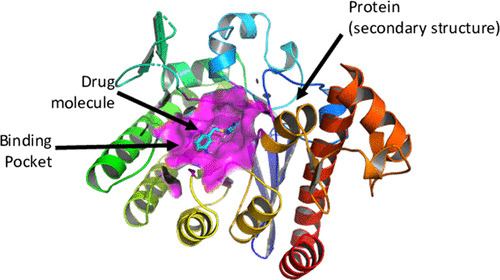

This is the full ligand receptor complex represented in each folder of PDBBIND v2016 dataset

**PDB file- Protein Data Bank**

In the PDB data file format for macromolecular models, each atom is designated either ATOM or HETATM (which stands for hetero atom).
ATOM is reserved for atoms in standard residues of protein, DNA or RNA.
HETATM is applied to non-standard residues of protein, DNA or RNA, as well as atoms in other kinds of groups, such as carbohydrates, substrates, ligands, solvent, and metal ions.

In [10]:
protein_df  = PandasPdb().read_pdb('/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/11gs/11gs_protein.pdb')
print(type(protein_df.df))
print(protein_df.df.keys())

<class 'dict'>
dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])


This dataframe has following important information
*   record_name : Type of element eg. Atom,heterogenous atom
*   XYZ coords : 3D cartesian coordinates of all the atoms in the protein
*   atom_name : Symbol of the atom
*   residue_name : Molecules from biochemistry eg. Prolyne,glycyne,adenine,thymine
*   chain_id : Some proteins have chains in them.
*   occupancy : Fraction of time a molecule is in that particular place or conformer. (if it's 1 then molecule is fixed in that particular position)
*   b_factor : Quantifies our uncertainity in the given XYZ coordinates
*   Charge : electric charge on that atom/group.





In [15]:
atom_df = protein_df.df['ATOM']
atom_df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,PRO,,A,2,,...,30.676,3.060,38.855,1.0,40.30,,,N,NaN,35
1,ATOM,2,,CA,,PRO,,A,2,,...,30.782,2.468,37.511,1.0,33.93,,,C,NaN,36
2,ATOM,3,,HA,,PRO,,A,2,,...,31.692,2.702,36.959,1.0,0.00,,,H,NaN,37
3,ATOM,4,,C,,PRO,,A,2,,...,29.570,3.000,36.767,1.0,24.70,,,C,NaN,38
4,ATOM,5,,O,,PRO,,A,2,,...,29.260,4.190,36.863,1.0,17.72,,,O,NaN,39


In [18]:
het_df = protein_df.df['HETATM']
het_df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,HETATM,6527,,O,,HOH,,,1,,...,30.973,0.731,12.888,1.0,14.90,,,O,NaN,6563
1,HETATM,6528,,O,,HOH,,,2,,...,16.353,5.845,8.714,1.0,13.46,,,O,NaN,6564
2,HETATM,6529,,O,,HOH,,,3,,...,18.802,9.871,22.399,1.0,19.85,,,O,NaN,6565
3,HETATM,6530,,O,,HOH,,,4,,...,17.849,-5.218,27.284,1.0,6.65,,,O,NaN,6566
4,HETATM,6531,,O,,HOH,,,5,,...,14.913,11.735,17.839,1.0,18.37,,,O,NaN,6567


Using a simple for loop, we can run through your protein model to see how many chains are in it. The code below  goes through ever chain in the protein_model, assigns in to the variable chain, and then prints the information.

In [ ]:
parser = Bio.PDB.PDBParser()
protein_struct = parser.get_structure('name', '/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/11gs/11gs_protein.pdb')
protein_model = protein_struct[0]
for chain in protein_model:
    print(chain)

<Chain id=A>
<Chain id=B>
<Chain id= >


Now we will access a particular chain, using the chain's id. For example, to access Chain A, we can use protein_model['A'].Let's see all the atoms in a particular protein chain.

In [ ]:
chain_A = protein_model['A']
res = chain_A[58]
print(res.get_unpacked_list())

[<Atom N>, <Atom H>, <Atom CA>, <Atom HA1>, <Atom HA2>, <Atom C>, <Atom O>]


# Ligand Structure Visualizations

Mol2 is a plain text tabular format that represents a single or multiple chemical compounds and holds atomic coordinates, chemical bond information, and metadata of a molecule.
We will be using biopandas library to visualize this file for the given ligand.

In [19]:
import os
import pandas as pd
from biopandas.mol2 import PandasMol2
def get_data_dict(file_path: str, to_replace:str="##########") -> dict:
    """get data headers from a mol2 file (assumes header lines start with `to_replace`)
    :parameter
        - file_path:
          path to the file of interest
        - to_replace:
          the 'marker' that specifies the header
    :return
        - data_dict
          dict containing the header parts as keys and their values as value
    """
    data_dict = {}
    # open and read file until all header info is read
    with open(file_path, "r") as mol2_file:
        for line in mol2_file:
            # contains header info
            if line.startswith(to_replace):
                key = None
                value = None
                for i in line.split(":"):
                    i = i.strip()
                    if to_replace in i:
                        key = i.replace(to_replace, "").strip()
                    else:
                        value = i
                data_dict[key] = [value]
            # header ended
            else:
                return data_dict

pmol = PandasMol2().read_mol2('/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/11gs/11gs_ligand.mol2')

After the file was succesfully loaded, we have access to the following basic PandasMol2 attributes:


In [ ]:
print('Molecule ID: %s' % pmol.code)
print('\nRaw MOL2 file contents:\n\n%s\n...' % pmol.mol2_text[:500])

Molecule ID: 11gs_ligand

Raw MOL2 file contents:

@<TRIPOS>MOLECULE
11gs_ligand
   66    66     1     0     0
SMALL
GAST_HUCK


@<TRIPOS>ATOM
      1 N1         14.7090   10.7820   23.2520 N.4       1 GTT         0.2328
      2 CA1        14.6200    9.9440   24.4710 C.3       1 GTT         0.0304
      3 C1         15.7480    8.9120   24.4560 C.2       1 GTT         0.0846
      4 O11        16.0850    8.4010   25.5410 O.co2     1 GTT        -0.5643
      5 O12        16.3130    8.6420   23.3670 O.co2     1 GTT        -0.5643
      6 CB1       
...


Most important attribute here is  the PandasMol2.df DataFrame, which contains the ATOM section of the MOL2 structure.


In [20]:
pmol.df

,atom_id,atom_name,x,y,z,atom_type,subst_id,subst_name,charge
0,1,N1,14.7090,10.7820,23.2520,N.4,1,GTT,0.2328
1,2,CA1,14.6200,9.9440,24.4710,C.3,1,GTT,0.0304
2,3,C1,15.7480,8.9120,24.4560,C.2,1,GTT,0.0846
3,4,O11,16.0850,8.4010,25.5410,O.co2,1,GTT,-0.5643
4,5,O12,16.3130,8.6420,23.3670,O.co2,1,GTT,-0.5643
...,...,...,...,...,...,...,...,...,...
61,62,H23,12.0415,3.1847,23.0981,H,1,GTT,0.0231
62,63,H24,10.1990,6.0171,24.8039,H,1,GTT,0.0403
63,64,H25,11.4535,5.0155,23.9979,H,1,GTT,0.0403
64,65,H26,4.2260,0.5740,28.1519,H,1,GTT,0.0788


**Data Format :**
*   atom_id (integer) = the ID number of the atom at the time the file was created.
*   atom_name (string) = the name of the atom.
*   x (real) = the x coordinate of the atom.
*   y (real) = the y coordinate of the atom.
*   z (real) = the z coordinate of the atom.
*   atom_type (string) = the SYBYL atom type for the atom.
*   subst_id (integer) = the ID number of the substructure containing the atom.
*   subst_name (string) = the name of the substructure containing the atom.
*   charge (real) = the charge associated with the atom.
*   status_bit (string) = the internal SYBYL status bits associated with the atom.






In [ ]:
#we can select all same type of atoms by filtering on the atom type column
keto = pmol.df[pmol.df['atom_type'] == 'O.2']
print('number of keto groups: %d' % keto.shape[0])
keto

number of keto groups: 3


,atom_id,atom_name,x,y,z,atom_type,subst_id,subst_name,charge
8,9,OE1,10.797,8.038,25.025,O.2,1,GTT,-0.3969
12,13,O2,10.085,7.888,29.591,O.2,1,GTT,-0.3944
28,29,O1,7.585,5.197,23.931,O.2,1,GTT,-0.3837


Let's see the counts of the different atom types that can be found in the MOL2 file

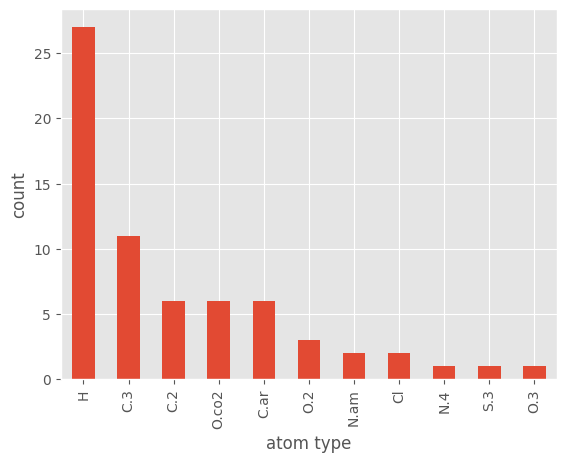

In [ ]:
pmol.df['atom_type'].value_counts().plot(kind='bar')
plt.xlabel('atom type')
plt.ylabel('count')
plt.show()

 Summarizing the different atom types by atomic elements:

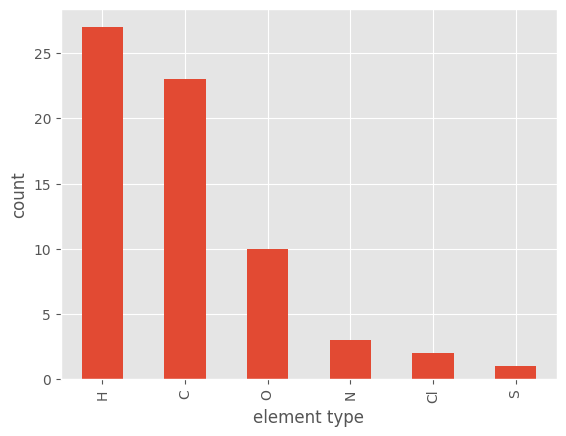

In [ ]:
pmol.df['element_type'] = pmol.df['atom_type'].apply(lambda x: x.split('.')[0])

pmol.df['element_type'].value_counts().plot(kind='bar')
plt.xlabel('element type')
plt.ylabel('count')
plt.show()

Plotting the average charge of the different atom types with the standard deviation as error bars:

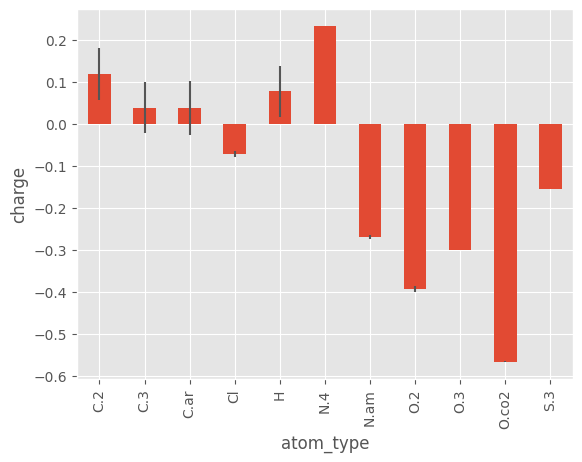

In [ ]:
groupby_charge = pmol.df.groupby(['atom_type'])['charge']
groupby_charge.mean().plot(kind='bar', yerr=groupby_charge.std())
plt.ylabel('charge')
plt.show()

# Binding affinity

In [ ]:
#binding affinities of protein-ligand complexes is in refined.2016 file
def get_binding_affinity(filename):
    '''
    Get the filename, output the list of kd/ki value corresponds to the complex file
    The affinity is in log(Ki) of log(Kd)
    '''
    map_complex_to_affinity = {}
    with open(filename) as f:
        for line in f:
            if line.startswith("#"):
                continue

            line = line.split()
            pdb_id, binding_affinity = line[0], line[3]

            map_complex_to_affinity[pdb_id] = float(binding_affinity)

    return map_complex_to_affinity

In [ ]:
map_complex_to_affinity = get_binding_affinity("/content/drive/MyDrive/binding_affinity_project/general-set-except-refined/index/INDEX_general_PL_data.2016")
df = pd.DataFrame(map_complex_to_affinity.items(), columns=['Complex', 'Affinity'])
df

,Complex,Affinity
0,3zzf,0.40
1,3gww,0.45
2,1w8l,0.49
3,3fqa,0.49
4,1zsb,0.60
...,...,...
13303,7cpa,13.96
13304,2xuf,14.39
13305,1avd,15.00
13306,2xui,15.00


# Affinity vs Complex plot

In [ ]:
import plotly.express as px
fig = px.scatter(df,x='Affinity',y= 'Complex')
fig.update_yaxes(showticklabels= False)
fig.update_xaxes(gridcolor='black', griddash='dash', minor_griddash="dot")
fig.show()